In [49]:
import platform
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from matplotlib import rc
from gensim.models import Word2Vec


In [50]:
dir = "../data/action_data.csv"
data = pd.read_csv(dir)
col = data.columns[:-1]
data = data[col]
data


,action,efficacy
0,명상,"이완, 혈액순환, 원활, 면역력 증가, 심신 안정, 스트레스 완화, 감정 조절, 수..."
1,운동,"체중 조절, 기분 전환 및 정신건강 증진 , 당뇨병과 대사 증후권 위험 감소, 뼈와..."
2,산책,"숙면에 도움, 수명 증가, 치매 예방, 몸매 유지, 스트레스 해소"
3,수면,"피부 관리, 고혈압 예방, 면역력 증진 , 건선 증상 완화 , 심장 질환 예방"
4,독서,"기억력 향상, 사고력 향상, 사회적 참여 촉진, 수면 도움 , 인지 능력 유연성 향상"
5,영화,영화는 우리에게 다양한 아이디어의 소스를 제공해줍니다. 대리만족과 공감을 할 수 있...
6,취미,"정신을 맑게 한다, 신감을 갖게 한다, 뇌를 건강하게 한다, 스트레스를 퇴치한다, ..."
7,요리,NaN
8,여행,NaN
9,식사,NaN


In [55]:
class check_data():
    def __init__(self,df):
        self.df = df
        self.wiki_model = Word2Vec.load('../ko/ko.bin')
        if platform.system() == 'Windows':
            self.font = 'Malgun Gothic'
        else:
            self.font = 'NanumGothic'

        self.eff = self.df.columns[1]
        self.df[f'{self.eff}_Morps'] = self.df[self.eff].map(lambda x: self.getMorps(x))
        self.df[f'{self.eff}_NV'] = self.df[f'{self.eff}_Morps'].map(lambda x: self.getNV(x))
        self.df[f'{self.eff}_N'] = self.df[f'{self.eff}_Morps'].map(lambda x: self.getN(x))
  
    def topn(self,n):
        self.df[f'{self.eff}_count_topn_NV']  = self.df[f'{self.eff}_NV'].map(lambda x: self.counter(x,n)) 
        self.df[f'{self.eff}_count_topn_N']  = self.df['{self.eff}_N'].map(lambda x: self.counter(x,n)) 

    def getMorps(self,sent):
        return Okt().pos(sent , norm=False , stem = True) 

    def getNV(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "
        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Verb' or morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        return s_result
    
    def getN(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "

        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        s_result = np.unique(s_result)
        return s_result

    def counter(self,sents, n):
        return sorted(collections.Counter(sents),reverse=True)[0:n]

    def get_heatmap(self, idx,figsize):
        plt.rc('font', family=self.font)
        result = []
        sents = self.df[f'{self.eff}_NV'][idx]
        effs_dims = ['에너지', '회복', '순환', '정화']
        
        
        for in_word in sents:
            sub_result = []
            for out_word in effs_dims:
                try:
                    sub_result.append(self.wiki_model.wv.similarity(out_word, in_word))
                except:
                    sub_result.append(0)
            result.append(sub_result)
        
        act_name = self.df['action'][idx]
        fig = plt.figure(figsize=figsize)
        fig.set_facecolor('white')
        plt.title(f'{act_name}에서 단어들간의 유사도 확인')
        sns.heatmap(result,annot=True)
        plt.xticks(np.arange(len(effs_dims)),effs_dims)
        plt.yticks(np.arange(len(sents)),sents)
        plt.show()
        
    def getDF(self):
        self.df.to_csv('data.csv')
        return self.df

    def result(self,idx, top , dis):
        effs_dims = ['에너지', '회복', '순환', '정화']
        sNV = self.df[f'{self.eff}_NV'][idx]

        result = []
        for dim in effs_dims:
            sub = []
            for word in sNV:
                try:
                    sub.append(self.wiki_model.wv.similarity(dim , word))
                except:
                    sub.append(0)
            tmp = np.sort(sub)[::-1][:top].mean()
            result.append(tmp)


        if dis == True:
            from matplotlib import rc
            plt.rc('font', family=self.font)

            word = self.df.iloc[idx][0]

            plt.figure()
            plt.bar(np.arange(len(result)),result)
            plt.title(f'{word}\'s mapping for top {top} using 대표어')
            plt.xticks(np.arange(len(effs_dims)), effs_dims)
            plt.yticks(np.arange(0,1.2,0.2))
            plt.show()
        return result

    def todf(self,file_name):
        ret_df  = pd.DataFrame(columns=['감정','에너지','회복','순환','정화'])
        em = []
        est_e= []
        est_h= []
        est_c= []
        est_p= []
        
        for idx in self.df.index:
            em.append(self.df['action'][idx])
            est = self.result(idx,3,False)
            est_e.append(est[0])        
            est_h.append(est[1])        
            est_c.append(est[2])        
            est_p.append(est[3])
        ret_df['감정'] = em        
        ret_df['에너지'] = est_e
        ret_df['회복'] = est_h
        ret_df['순환'] = est_c
        ret_df['정화'] = est_p
        
        ret_df.to_csv(file_name,index=False)
        return ret_df

C:\Users\zesky\AppData\Local\Temp/ipykernel_21556/4163534807.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[f'{self.eff}_Morps'] = self.df[self.eff].map(lambda x: self.getMorps(x))
C:\Users\zesky\AppData\Local\Temp/ipykernel_21556/4163534807.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[f'{self.eff}_NV'] = self.df[f'{self.eff}_Morps'].map(lambda x: self.getNV(x))
C:\Users\zesky\AppData\Local\Temp/ipykernel_21556/4163534807.py:13: SettingWithCopyWarning: 
A value is trying to be 

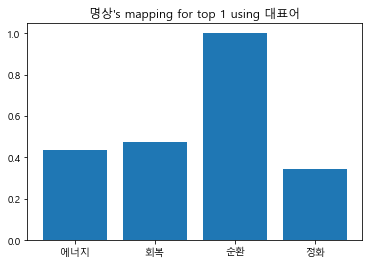

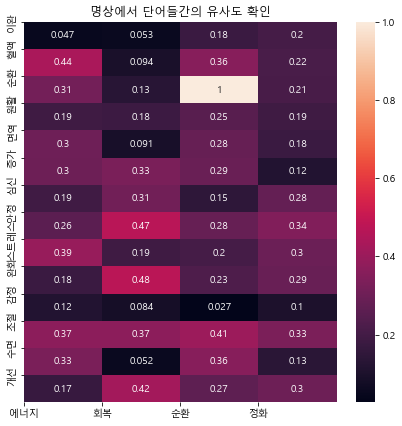

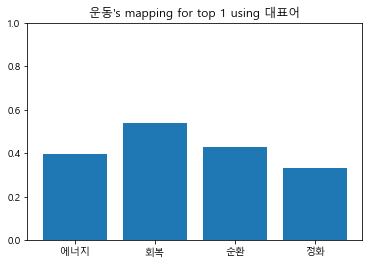

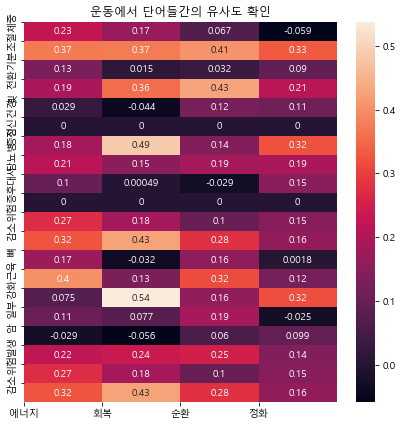

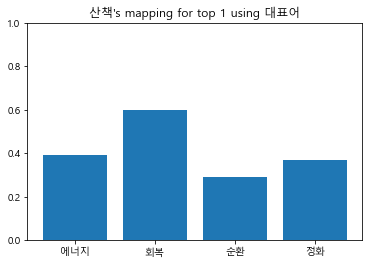

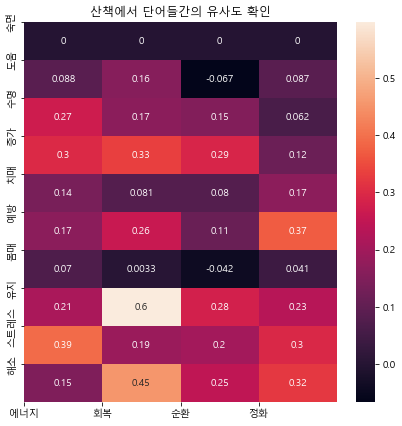

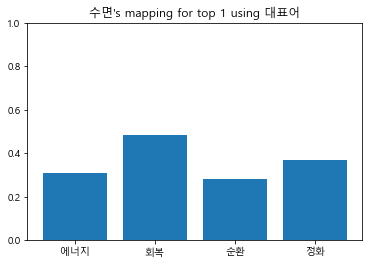

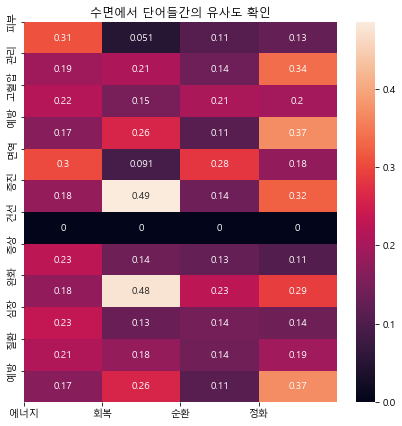

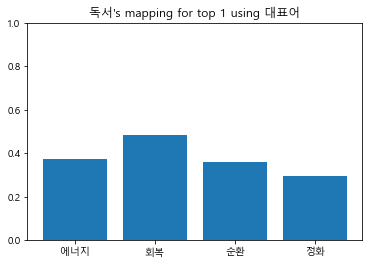

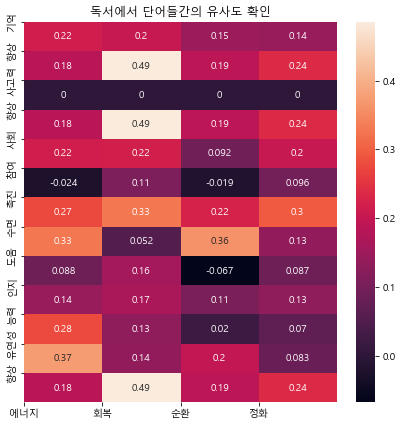

In [56]:
XYZ = check_data(data[0:5])
#XYZ.get_heatmap(0,(10,10))
for i in range(0,5):
    XYZ.result(i,1,True)
    XYZ.get_heatmap(i,(7,7))

In [53]:
XYZ = check_data(data[0:5])
data.head()
XYZ.todf("../result/action_estimation.csv")

C:\Users\zesky\AppData\Local\Temp/ipykernel_21556/4277149948.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[f'{self.eff}_Morps'] = self.df[self.eff].map(lambda x: self.getMorps(x))
C:\Users\zesky\AppData\Local\Temp/ipykernel_21556/4277149948.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[f'{self.eff}_NV'] = self.df[f'{self.eff}_Morps'].map(lambda x: self.getNV(x))
C:\Users\zesky\AppData\Local\Temp/ipykernel_21556/4277149948.py:13: SettingWithCopyWarning: 
A value is trying to be 

,감정,에너지,회복,순환,정화
0,명상,0.400750,0.455728,0.589044,0.325155
1,운동,0.364873,0.483403,0.383764,0.324081
2,산책,0.320345,0.461215,0.271852,0.328704
3,수면,0.281741,0.407013,0.238239,0.359288
4,독서,0.326346,0.485431,0.260725,0.255343
